In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices)) 

1


In [3]:
img_df = pd.read_csv("photos/image_labels.csv")
img_df.head()

,path,class,label,image_id
0,one_1.jpg,one,0,11
1,one_10.jpg,one,0,11
2,one_11.jpg,one,0,11
3,one_12.jpg,one,0,11
4,one_13.jpg,one,0,11


In [4]:
len(img_df)

992

### Resize images

In [7]:
from PIL import Image

(new_width, new_height) = (128, 128)

path = "photos/original/"
filenames = img_df["path"]

for filename in filenames:
    with Image.open(f"{path}/{filename}") as im:
        width, height = im.size
        if height >= width:
            left = 0
            top = (height-width)/2
            right = width
            bottom = width+(height-width)/2
        else:
            left = (width-height)/2
            top = 0
            right = height+(width-height)/2
            bottom = height
        im_cropped = im.crop((left, top, right, bottom))
        im_resized = im_cropped.resize((new_width, new_height), resample=Image.HAMMING)
        im_resized.save(f"photos/resized/128/{filename}")

### Create dataset

In [33]:
filenames = img_df["path"]
labels = img_df["label"]
classes = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", 
           "Alphabet_A", "Alphabet_B", "Alphabet_C", "Alphabet_D", "Alphabet_E", "Alphabet_F", "Alphabet_G", "Alphabet_H", "Alphabet_S", "Alphabet_T", "Alphabet_U", "Alphabet_v", "Alphabet_w", "Alphabet_x", "Alphabet_y", "Alphabet_z", 
           "up_arrow", "down_arrow", "right_arrow", "left_arrow", "Stop", "Bullseye"]

In [34]:
def decode_images(file):
  path = f"./photos/resized/128/{file}"
  print(path)
  image_decoded = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)/255
  im = tf.cast(image_decoded, tf.float32)
  return im

decoded_images = list(map(lambda file: decode_images(file), list(filenames)))

./photos/resized/224/one_1.jpg
./photos/resized/224/one_10.jpg
./photos/resized/224/one_11.jpg
./photos/resized/224/one_12.jpg
./photos/resized/224/one_13.jpg
./photos/resized/224/one_14.jpg
./photos/resized/224/one_15.jpg
./photos/resized/224/one_16.jpg
./photos/resized/224/one_17.jpg
./photos/resized/224/one_18.jpg
./photos/resized/224/one_19.jpg
./photos/resized/224/one_2.jpg
./photos/resized/224/one_20.jpg
./photos/resized/224/one_21.jpg
./photos/resized/224/one_22.jpg
./photos/resized/224/one_23.jpg
./photos/resized/224/one_24.jpg
./photos/resized/224/one_25.jpg
./photos/resized/224/one_26.jpg
./photos/resized/224/one_27.jpg
./photos/resized/224/one_28.jpg
./photos/resized/224/one_29.jpg
./photos/resized/224/one_3.jpg
./photos/resized/224/one_30.jpg
./photos/resized/224/one_31.jpg
./photos/resized/224/one_32.jpg
./photos/resized/224/one_4.jpg
./photos/resized/224/one_5.jpg
./photos/resized/224/one_6.jpg
./photos/resized/224/one_7.jpg
./photos/resized/224/one_8.jpg
./photos/resized

In [35]:
print(decoded_images[1])

tf.Tensor(
[[[0.5882353  0.50980395 0.48235294]
  [0.58431375 0.5058824  0.47843137]
  [0.58431375 0.5058824  0.47843137]
  ...
  [0.7882353  0.8352941  0.827451  ]
  [0.84313726 0.8901961  0.88235295]
  [0.88235295 0.92941177 0.9137255 ]]

 [[0.58431375 0.5058824  0.47843137]
  [0.58431375 0.5058824  0.47843137]
  [0.5803922  0.5019608  0.4745098 ]
  ...
  [0.8862745  0.93333334 0.93333334]
  [0.90588236 0.9529412  0.94509804]
  [0.9098039  0.95686275 0.9490196 ]]

 [[0.58431375 0.5058824  0.47843137]
  [0.5803922  0.5019608  0.4745098 ]
  [0.5803922  0.5019608  0.4745098 ]
  ...
  [0.972549   1.         1.        ]
  [0.972549   1.         1.        ]
  [0.95686275 0.99607843 1.        ]]

 ...

 [[0.3019608  0.32156864 0.3372549 ]
  [0.3019608  0.32156864 0.3372549 ]
  [0.3019608  0.32156864 0.3372549 ]
  ...
  [0.7294118  0.7607843  0.7176471 ]
  [0.7294118  0.7607843  0.7176471 ]
  [0.7254902  0.75686276 0.7137255 ]]

 [[0.3019608  0.32156864 0.3372549 ]
  [0.3019608  0.32156864 0

In [36]:
labels = tf.constant(labels)

In [37]:
print(labels)

tf.Tensor(
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9 10 10 10 10 10 

In [38]:
dataset = tf.data.Dataset.from_tensor_slices((decoded_images, labels))

In [39]:
len(dataset)

992

In [40]:
dataset = dataset.shuffle(1000)

In [41]:
dataset

<ShuffleDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Text(0.5, 1.0, 'eight')

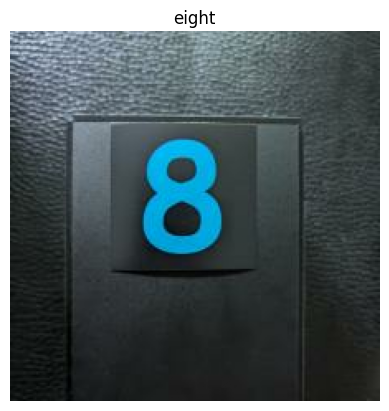

In [42]:
image, label = next(iter(dataset))
plt.imshow(image)
plt.axis("off")
plt.title(classes[label])

In [43]:
path = "./datasets/original_128"

dataset.save(path)

### Data augmentation

In [78]:
path = "./datasets/original_128"

dataset = tf.data.Dataset.load(path)


In [79]:
len(dataset)

992

In [80]:
dataset = dataset.shuffle(1000)

In [81]:
classes = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", 
           "Alphabet_A", "Alphabet_B", "Alphabet_C", "Alphabet_D", "Alphabet_E", "Alphabet_F", "Alphabet_G", "Alphabet_H", "Alphabet_S", "Alphabet_T", "Alphabet_U", "Alphabet_v", "Alphabet_w", "Alphabet_x", "Alphabet_y", "Alphabet_z", 
           "up_arrow", "down_arrow", "right_arrow", "left_arrow", "Stop", "Bullseye"]

In [87]:
data_augmentation = keras.Sequential(
  [
    layers.RandomZoom(0.25, fill_mode="nearest"),
    layers.RandomRotation(0.005, fill_mode="nearest"),
    layers.RandomBrightness(0.0003),
    layers.RandomContrast(0.0003)
  ]
)

Text(0.5, 1.0, 'Alphabet_x')

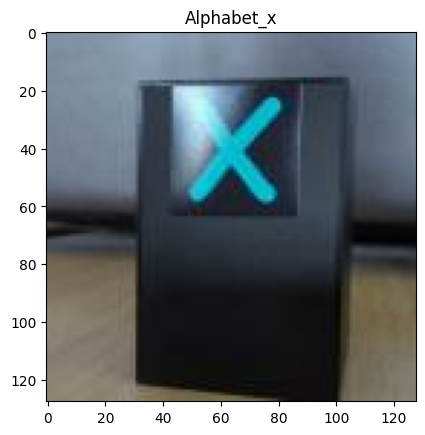

In [88]:
image, label = next(iter(dataset))
plt.imshow(image)
plt.title(classes[label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


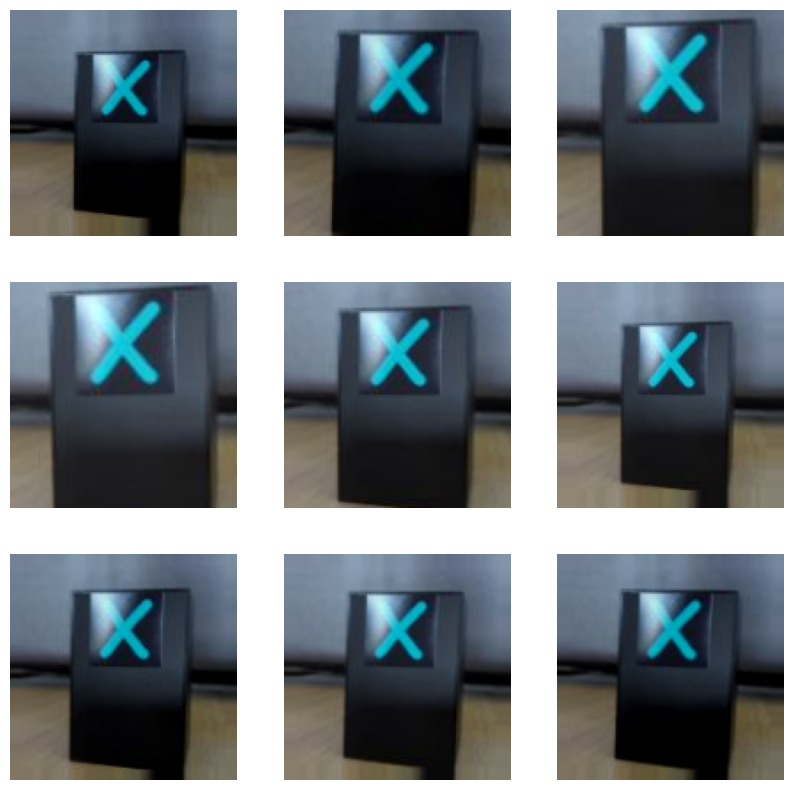

In [90]:
plt.figure(figsize=(10, 10))
for i in range(9):
  new_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(new_image)
  plt.axis("off")

In [91]:
for i in range(10):
    new_images = tf.reshape(tf.constant([], dtype=tf.dtypes.float32), (0, 128, 128, 3))
    new_labels = tf.reshape(tf.constant([], dtype=tf.dtypes.int64), (0))    
    for image, label in dataset:
        new_image = data_augmentation(image)
        new_images = tf.concat([new_images,  tf.expand_dims(new_image, 0)], axis=0)
        new_labels = tf.concat([new_labels, tf.expand_dims(label, 0)], axis=0)
    if i == 0:
        add_dataset = tf.data.Dataset.from_tensor_slices((new_images, new_labels))
    else:
        temp_dataset = tf.data.Dataset.from_tensor_slices((new_images, new_labels))
        add_dataset = add_dataset.concatenate(temp_dataset)
    print(f"Iteration {i+1}")


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


In [92]:
dataset = dataset.concatenate(add_dataset)

In [93]:
print(len(dataset))

10912


In [94]:
dataset = dataset.shuffle(11000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Alphabet_F')

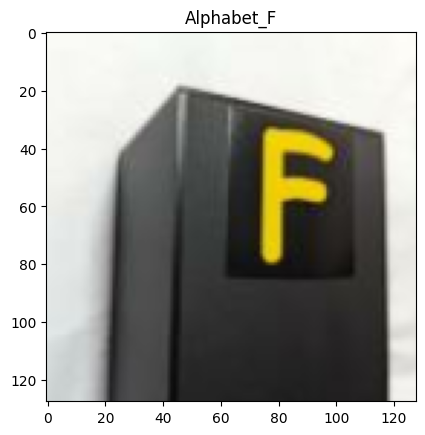

In [103]:
image, label = next(iter(dataset))
plt.imshow(image)
plt.title(classes[label])

In [104]:
print(image)

tf.Tensor(
[[[0.98101336 0.9849338  0.9653234 ]
  [0.98101336 0.9849338  0.9653234 ]
  [0.98101336 0.9849338  0.9653234 ]
  ...
  [0.9950284  0.99110705 0.9714967 ]
  [0.99135    0.9874287  0.9678183 ]
  [0.98897517 0.98505384 0.96544343]]

 [[0.98101336 0.9849338  0.9653234 ]
  [0.98101336 0.9849338  0.9653234 ]
  [0.98101336 0.9849338  0.9653234 ]
  ...
  [0.99508774 0.99116635 0.971556  ]
  [0.99226004 0.9883387  0.96872836]
  [0.99076974 0.98684853 0.9672381 ]]

 [[0.9810134  0.9849338  0.9653234 ]
  [0.98101336 0.9849338  0.9653234 ]
  [0.98101336 0.9849338  0.9653234 ]
  ...
  [0.9951173  0.991196   0.97158563]
  [0.99274963 0.98882836 0.96921796]
  [0.9923676  0.9884463  0.9688359 ]]

 ...

 [[0.8174807  0.84100544 0.8409994 ]
  [0.80785286 0.83137774 0.8313717 ]
  [0.7997029  0.8232277  0.8232217 ]
  ...
  [0.94812095 0.9441997  0.92851007]
  [0.94672996 0.9428086  0.9271191 ]
  [0.94664645 0.9427251  0.9270356 ]]

 [[0.8137746  0.83729947 0.8372935 ]
  [0.8049642  0.828489   0

In [105]:
path = "./datasets/full_128"

dataset.save(path)

### Train-test-val split

In [5]:
path = "./datasets/full_128"

full_dataset = tf.data.Dataset.load(path)


In [6]:
classes = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", 
           "Alphabet_A", "Alphabet_B", "Alphabet_C", "Alphabet_D", "Alphabet_E", "Alphabet_F", "Alphabet_G", "Alphabet_H", "Alphabet_S", "Alphabet_T", "Alphabet_U", "Alphabet_v", "Alphabet_w", "Alphabet_x", "Alphabet_y", "Alphabet_z", 
           "up_arrow", "down_arrow", "right_arrow", "left_arrow", "Stop", "Bullseye"]

In [7]:
len(full_dataset)

10912

In [8]:
full_dataset = full_dataset.shuffle(11000)

In [11]:
val_size = test_size = int(0.15*len(full_dataset))
train_size = len(full_dataset) - val_size - test_size

train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

print(len(train_dataset), len(val_dataset), len(test_dataset))

7640 1636 1636


In [111]:
#check if all datasets contain all classes
train_labels = []
for image, label in train_dataset:
    train_labels.append(int(label))

print(len(np.unique(train_labels)))

val_labels = []
for image, label in val_dataset:
    val_labels.append(int(label))

print(len(np.unique(val_labels)))

test_labels = []
for image, label in test_dataset:
    test_labels.append(int(label))

print(len(np.unique(test_labels)))

31
31
31


In [12]:
batch_size = 64

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [13]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### CNN

In [32]:
img_shape = (128, 128, 3,)

In [33]:
data_augmentation = keras.Sequential(
  [
    layers.RandomZoom(0.1, fill_mode="nearest"),
    layers.RandomRotation(0.003, fill_mode="nearest"),
    layers.RandomBrightness(0.0001),
    layers.RandomContrast(0.0001)
  ]
)

Text(0.5, 1.0, 'Alphabet_w')

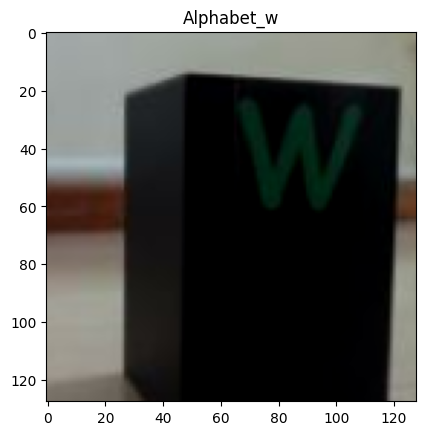

In [20]:
images, labels = next(iter(train_dataset))
plt.imshow(images[0])
plt.title(classes[labels[0]])

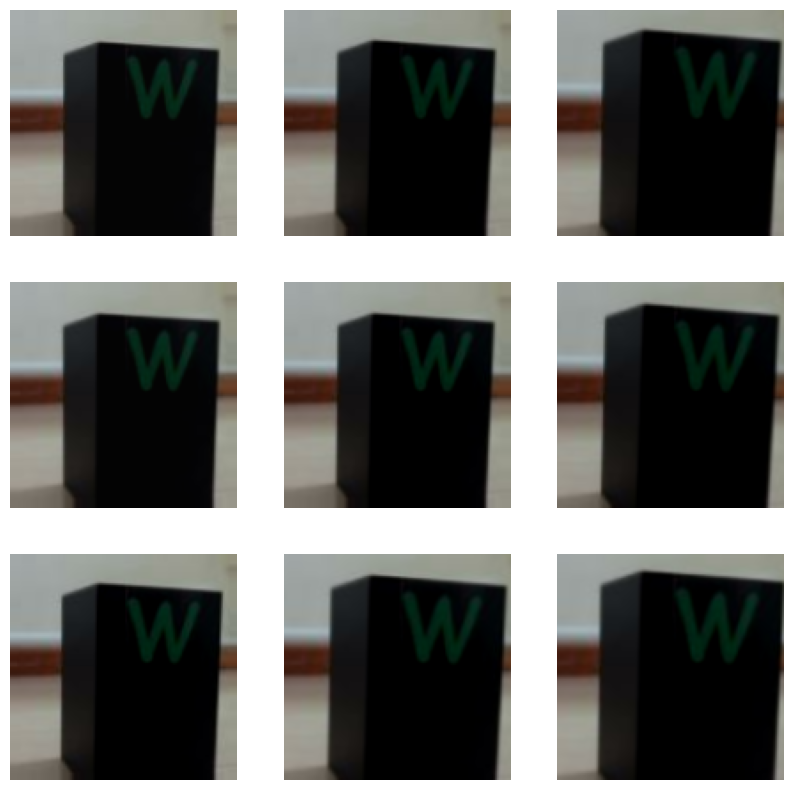

In [21]:
plt.figure(figsize=(10, 10))
for i in range(9):
  new_image = data_augmentation(images[0])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(new_image)
  plt.axis("off")

In [34]:
cnn_model = Sequential([
  keras.Input(shape=img_shape),
  data_augmentation,
  layers.Conv2D(12, 3, activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(24, 3, activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(48, 3, activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling2D(),
  layers.Dense(len(classes))
])


In [35]:
import tensorflow_addons as tfa

#optimizer = tfa.optimizers.AdamW(weight_decay=0.004, learning_rate=0.001)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [36]:
cnn_model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [37]:
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 12)      336       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 12)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 24)        2616      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 24)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 48)       

In [38]:
epochs = 20

history = cnn_model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/20


120/120 [==============================] - 155s 1s/step - loss: 3.4029 - accuracy: 0.0476 - val_loss: 3.2295 - val_accuracy: 0.0697
Epoch 2/20
120/120 [==============================] - 151s 1s/step - loss: 2.9872 - accuracy: 0.0804 - val_loss: 2.8601 - val_accuracy: 0.0727
Epoch 3/20
120/120 [==============================] - 300s 2s/step - loss: 2.7281 - accuracy: 0.1152 - val_loss: 2.5443 - val_accuracy: 0.1693
Epoch 4/20
120/120 [==============================] - 279s 1s/step - loss: 2.3105 - accuracy: 0.1751 - val_loss: 2.0947 - val_accuracy: 0.2042
Epoch 5/20
120/120 [==============================] - 115s 917ms/step - loss: 2.0467 - accuracy: 0.2130 - val_loss: 1.9883 - val_accuracy: 0.2304
Epoch 6/20
120/120 [==============================] - 116s 928ms/step - loss: 1.9540 - accuracy: 0.2366 - val_loss: 1.8629 - val_accuracy: 0.3001
Epoch 7/20
120/120 [==============================] - 115s 917ms/step - loss: 1.8990 - accuracy: 0.2445 - val_loss: 1.8435 - val_accuracy: 0.2506
E

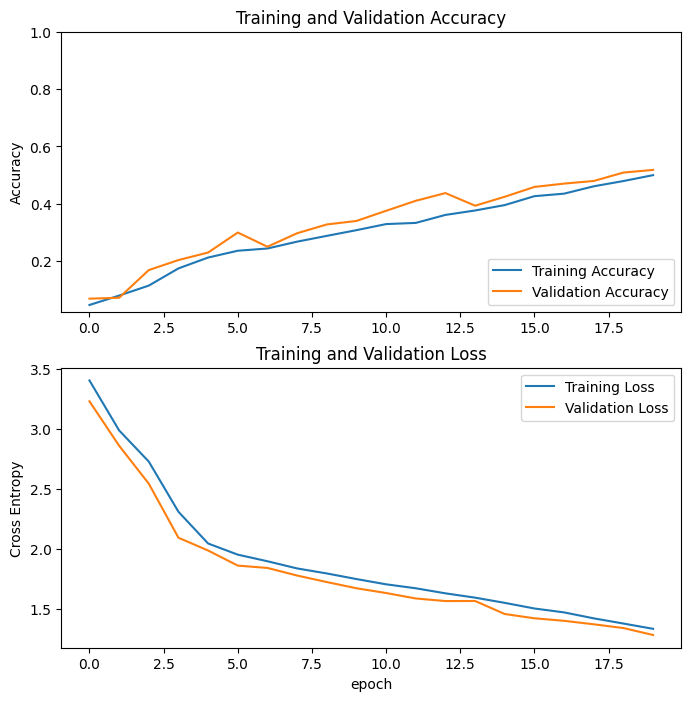

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
#train for another 20 epochs
epochs = 20

history1 = cnn_model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/20
120/120 [==============================] - 121s 958ms/step - loss: 1.2846 - accuracy: 0.5209 - val_loss: 1.1813 - val_accuracy: 0.5886
Epoch 2/20
120/120 [==============================] - 123s 970ms/step - loss: 1.2353 - accuracy: 0.5403 - val_loss: 1.2045 - val_accuracy: 0.5727
Epoch 3/20
120/120 [==============================] - 118s 933ms/step - loss: 1.1906 - accuracy: 0.5596 - val_loss: 1.1633 - val_accuracy: 0.5874
Epoch 4/20
120/120 [==============================] - 118s 934ms/step - loss: 1.1564 - accuracy: 0.5787 - val_loss: 1.0256 - val_accuracy: 0.6601
Epoch 5/20
120/120 [==============================] - 116s 914ms/step - loss: 1.1004 - accuracy: 0.6037 - val_loss: 1.0382 - val_accuracy: 0.6253
Epoch 6/20
120/120 [==============================] - 117s 920ms/step - loss: 1.0613 - accuracy: 0.6161 - val_loss: 1.0005 - val_accuracy: 0.6406
Epoch 7/20
120/120 [==============================] - 117s 922ms/step - loss: 1.0090 - accuracy: 0.6338 - val_loss: 0.9396 -

In [41]:
total_history_dict = dict()

for some_key in history.history.keys():
    current_values = [] # to save values from all history dicts
    for hist_dict in [history.history, history1.history]:
        current_values += hist_dict[some_key]
    total_history_dict[some_key] = current_values

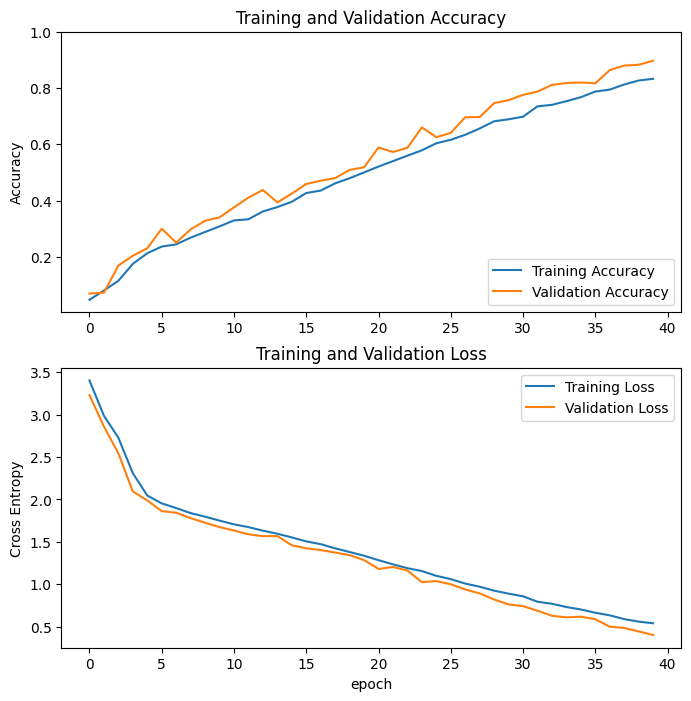

In [42]:
acc = total_history_dict['accuracy']
val_acc = total_history_dict['val_accuracy']

loss = total_history_dict['loss']
val_loss = total_history_dict['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [44]:
#train for another 10 epochs
epochs = 10

history2 = cnn_model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/10


120/120 [==============================] - 124s 978ms/step - loss: 0.5091 - accuracy: 0.8404 - val_loss: 0.3981 - val_accuracy: 0.8936
Epoch 2/10
120/120 [==============================] - 120s 943ms/step - loss: 0.4770 - accuracy: 0.8548 - val_loss: 0.3430 - val_accuracy: 0.9211
Epoch 3/10
120/120 [==============================] - 120s 939ms/step - loss: 0.4580 - accuracy: 0.8611 - val_loss: 0.3513 - val_accuracy: 0.9077
Epoch 4/10
120/120 [==============================] - 122s 960ms/step - loss: 0.4353 - accuracy: 0.8674 - val_loss: 0.3430 - val_accuracy: 0.9126
Epoch 5/10
120/120 [==============================] - 122s 958ms/step - loss: 0.4040 - accuracy: 0.8771 - val_loss: 0.3043 - val_accuracy: 0.9169
Epoch 6/10
120/120 [==============================] - 122s 959ms/step - loss: 0.3825 - accuracy: 0.8848 - val_loss: 0.3119 - val_accuracy: 0.9040
Epoch 7/10
120/120 [==============================] - 122s 959ms/step - loss: 0.3953 - accuracy: 0.8834 - val_loss: 0.2783 - val_accura

In [45]:
total_history_dict = dict()

for some_key in history.history.keys():
    current_values = [] # to save values from all history dicts
    for hist_dict in [history.history, history1.history, history2.history]:
        current_values += hist_dict[some_key]
    total_history_dict[some_key] = current_values

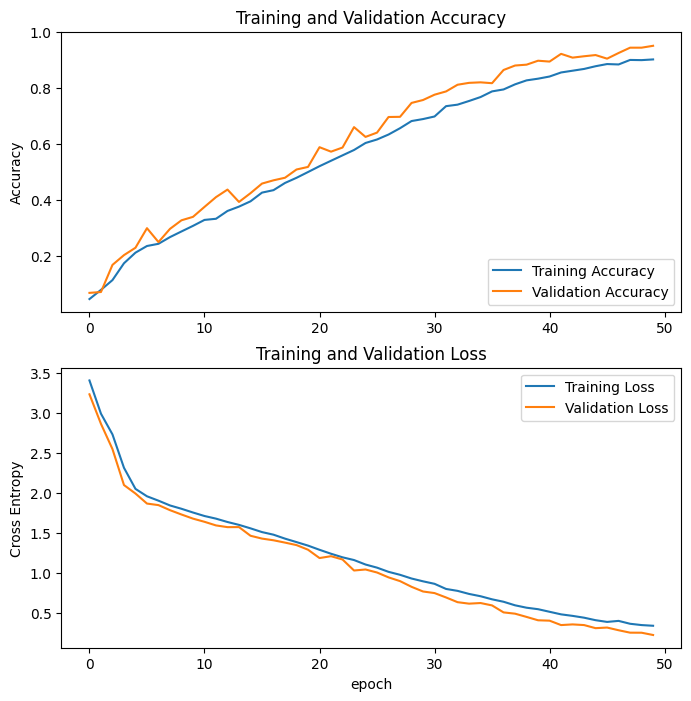

In [46]:
acc = total_history_dict['accuracy']
val_acc = total_history_dict['val_accuracy']

loss = total_history_dict['loss']
val_loss = total_history_dict['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [47]:
results = cnn_model.evaluate(test_dataset, batch_size=64)
print("test loss, test acc:", results)

26/26 [==============================] - 9s 27ms/step - loss: 0.2015 - accuracy: 0.9566
test loss, test acc: [0.20152416825294495, 0.9566014409065247]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


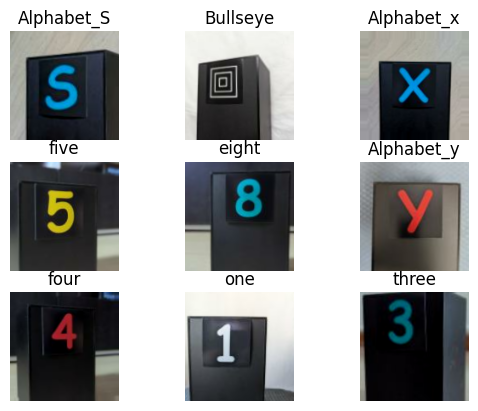

In [48]:
images, labels = next(iter(test_dataset))
preds = cnn_model(images)
preds = tf.math.argmax(preds, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[int(preds[i])])
    plt.axis("off")

In [49]:
cnn_model.save("./models/cnn_model.keras")

#### depthwise convolution

In [58]:
cnn_model_dw = Sequential([
  keras.Input(shape=img_shape),
  data_augmentation,
  layers.SeparableConv2D(12, 3, 1, depth_multiplier=1, activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.SeparableConv2D(24, 3, 1, depth_multiplier=1, activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.SeparableConv2D(48, 3, 1, depth_multiplier=1, activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling2D(),
  layers.Dense(len(classes))
])


In [59]:
import tensorflow_addons as tfa

#optimizer = tfa.optimizers.AdamW(weight_decay=0.004, learning_rate=0.001)
optimizer = keras.optimizers.Adam(learning_rate=0.01)

In [60]:
cnn_model_dw.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [61]:
cnn_model_dw.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 separable_conv2d_6 (Separab  (None, 126, 126, 12)     75        
 leConv2D)                                                       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 63, 63, 12)       0         
 g2D)                                                            
                                                                 
 separable_conv2d_7 (Separab  (None, 61, 61, 24)       420       
 leConv2D)                                                       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 30, 24)       0         
 g2D)                                                 

In [62]:
epochs = 20

history = cnn_model_dw.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/20


120/120 [==============================] - 127s 969ms/step - loss: 3.4379 - accuracy: 0.0297 - val_loss: 3.4113 - val_accuracy: 0.0312
Epoch 2/20
120/120 [==============================] - 131s 1s/step - loss: 3.0567 - accuracy: 0.0668 - val_loss: 2.9452 - val_accuracy: 0.0733
Epoch 3/20
120/120 [==============================] - 129s 1s/step - loss: 2.7927 - accuracy: 0.0970 - val_loss: 2.6657 - val_accuracy: 0.1161
Epoch 4/20
120/120 [==============================] - 123s 971ms/step - loss: 2.6584 - accuracy: 0.1136 - val_loss: 2.6732 - val_accuracy: 0.1192
Epoch 5/20
120/120 [==============================] - 123s 968ms/step - loss: 2.6092 - accuracy: 0.1237 - val_loss: 2.5764 - val_accuracy: 0.1400
Epoch 6/20
120/120 [==============================] - 123s 966ms/step - loss: 2.5755 - accuracy: 0.1332 - val_loss: 2.5326 - val_accuracy: 0.1614
Epoch 7/20
120/120 [==============================] - 123s 966ms/step - loss: 2.5737 - accuracy: 0.1408 - val_loss: 2.5521 - val_accuracy: 0.

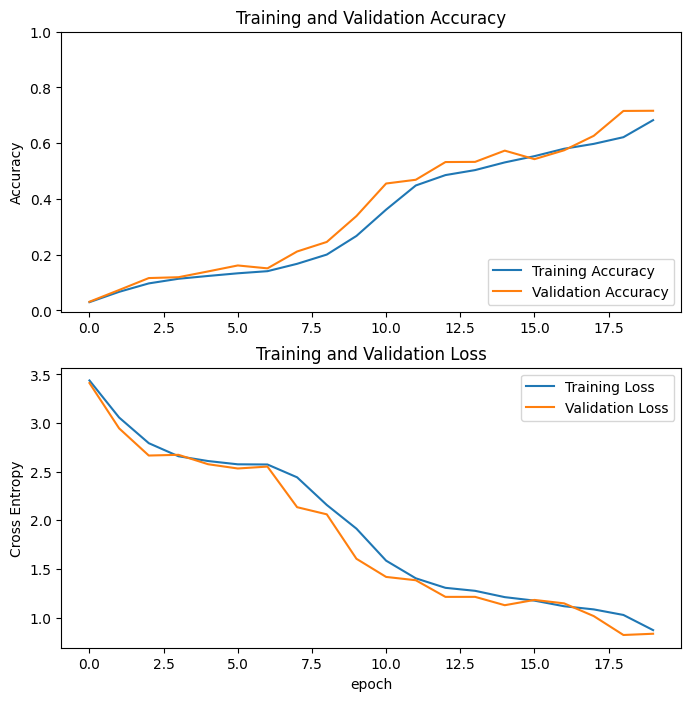

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [64]:
#train for another 30 epochs
epochs = 30

history1 = cnn_model_dw.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/30


120/120 [==============================] - 127s 1s/step - loss: 0.7577 - accuracy: 0.7338 - val_loss: 0.7152 - val_accuracy: 0.7378
Epoch 2/30
120/120 [==============================] - 122s 962ms/step - loss: 0.6564 - accuracy: 0.7703 - val_loss: 0.5424 - val_accuracy: 0.7958
Epoch 3/30
120/120 [==============================] - 122s 962ms/step - loss: 0.5870 - accuracy: 0.7878 - val_loss: 0.4735 - val_accuracy: 0.8319
Epoch 4/30
120/120 [==============================] - 123s 972ms/step - loss: 0.5191 - accuracy: 0.8186 - val_loss: 0.4012 - val_accuracy: 0.8735
Epoch 5/30
120/120 [==============================] - 123s 969ms/step - loss: 0.4648 - accuracy: 0.8433 - val_loss: 0.4674 - val_accuracy: 0.8337
Epoch 6/30
120/120 [==============================] - 124s 976ms/step - loss: 0.4081 - accuracy: 0.8641 - val_loss: 0.3008 - val_accuracy: 0.8973
Epoch 7/30
120/120 [==============================] - 119s 931ms/step - loss: 0.4795 - accuracy: 0.8602 - val_loss: 0.3389 - val_accuracy:

In [65]:
total_history_dict = dict()

for some_key in history.history.keys():
    current_values = [] # to save values from all history dicts
    for hist_dict in [history.history, history1.history]:
        current_values += hist_dict[some_key]
    total_history_dict[some_key] = current_values

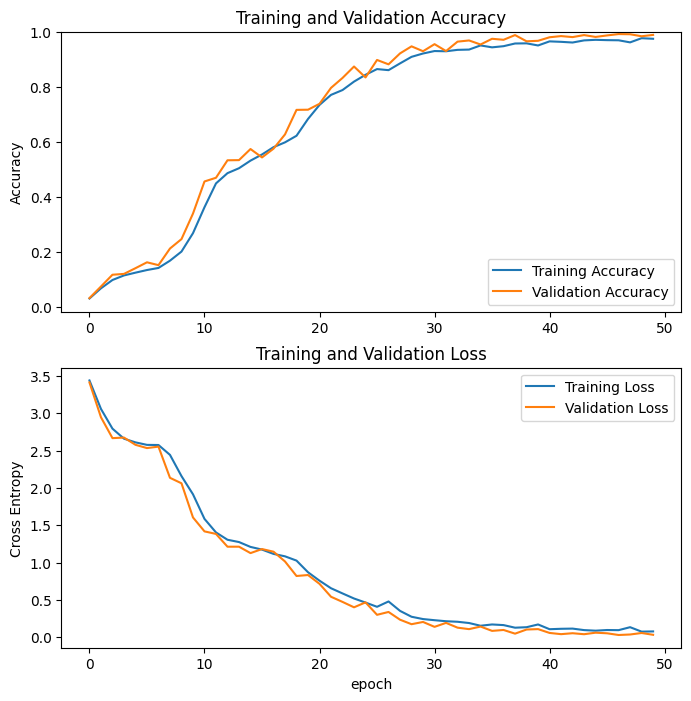

In [66]:
acc = total_history_dict['accuracy']
val_acc = total_history_dict['val_accuracy']

loss = total_history_dict['loss']
val_loss = total_history_dict['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [67]:
results = cnn_model_dw.evaluate(test_dataset, batch_size=32)
print("test loss, test acc:", results)

26/26 [==============================] - 9s 30ms/step - loss: 0.0341 - accuracy: 0.9896
test loss, test acc: [0.03408414125442505, 0.9896088242530823]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


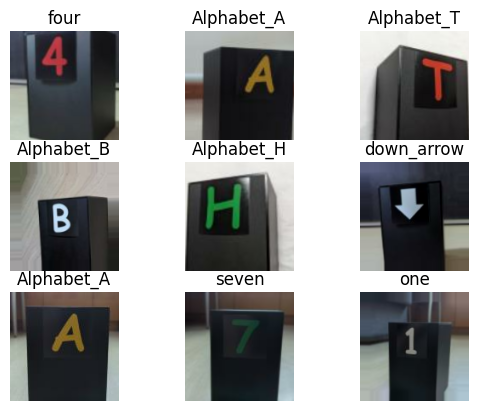

In [70]:
images, labels = next(iter(test_dataset))
preds = cnn_model_dw(images)
preds = tf.math.argmax(preds, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[int(preds[i])])
    plt.axis("off")

In [69]:
cnn_model_dw.save("./models/cnn_model_dw.keras")

### Finetune pretrained model

In [110]:
img_shape = (128, 128, 3)

In [111]:
mobnetv3 = keras.applications.MobileNetV3Small(
  input_shape=img_shape,
  classes=len(classes),
  include_top=False,
  weights='imagenet',
  pooling=None,
  include_preprocessing=True
)

In [112]:
mobnetv3.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_12 (Rescaling)       (None, 128, 128, 3)  0           ['input_19[0][0]']               
                                                                                                  
 Conv (Conv2D)                  (None, 64, 64, 16)   432         ['rescaling_12[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 64, 64, 16)  64          ['Conv[0][0]']    

In [113]:
len(mobnetv3.layers)

229

In [114]:
for layer in mobnetv3.layers:
    layer.trainable = True


In [115]:
mobnetv3_ft = keras.Sequential([
  keras.Input(shape=img_shape), 
  data_augmentation,
  layers.Rescaling(255),
  mobnetv3,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.2),
  layers.Dense(128, activation="relu"),
  layers.Dense(len(classes))
])

In [116]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = mobnetv3_ft(image_batch)
print(feature_batch.shape)

(64, 31)


In [117]:
mobnetv3_ft.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, None, None, 3)     0         
                                                                 
 rescaling_13 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 4, 4, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_9   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_9 (Dropout)         (None, 576)               0         
                                                                 
 dense_13 (Dense)            (None, 128)             

In [118]:
import tensorflow_addons as tfa

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
#optimizer = tfa.optimizers.AdamW(weight_decay=0.004, learning_rate=0.0001)

In [119]:
mobnetv3_ft.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [120]:
epochs = 10

history_mobnet = mobnetv3_ft.fit(train_dataset,
                                epochs=epochs,
                                validation_data=val_dataset)

Epoch 1/10


120/120 [==============================] - 140s 1s/step - loss: 2.9545 - accuracy: 0.2055 - val_loss: 2.6255 - val_accuracy: 0.2555
Epoch 2/10
120/120 [==============================] - 132s 1s/step - loss: 0.8624 - accuracy: 0.7853 - val_loss: 1.3257 - val_accuracy: 0.5544
Epoch 3/10
120/120 [==============================] - 132s 1s/step - loss: 0.2043 - accuracy: 0.9478 - val_loss: 0.7809 - val_accuracy: 0.7194
Epoch 4/10
120/120 [==============================] - 132s 1s/step - loss: 0.0822 - accuracy: 0.9808 - val_loss: 0.4724 - val_accuracy: 0.8368
Epoch 5/10
120/120 [==============================] - 133s 1s/step - loss: 0.0442 - accuracy: 0.9902 - val_loss: 0.2265 - val_accuracy: 0.9224
Epoch 6/10
120/120 [==============================] - 134s 1s/step - loss: 0.0274 - accuracy: 0.9945 - val_loss: 0.1088 - val_accuracy: 0.9688
Epoch 7/10
120/120 [==============================] - 132s 1s/step - loss: 0.0180 - accuracy: 0.9970 - val_loss: 0.0556 - val_accuracy: 0.9829
Epoch 8/10

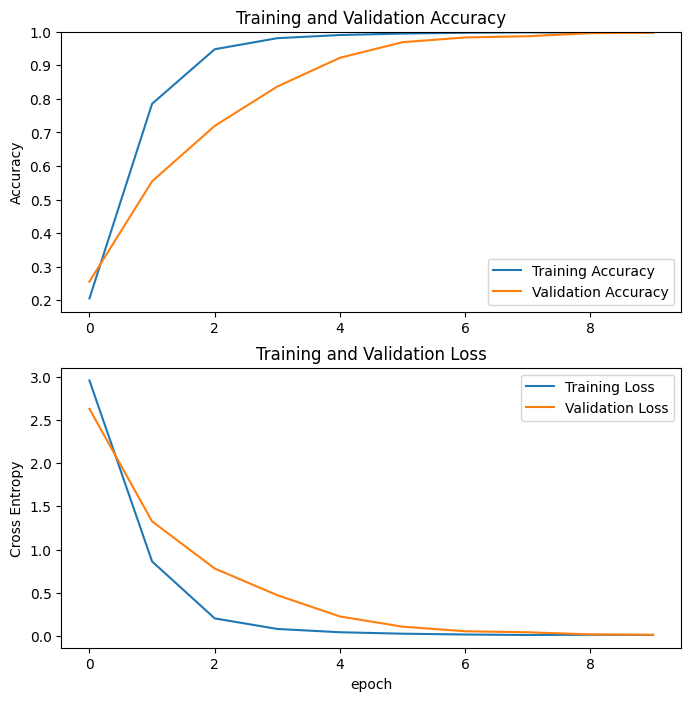

In [121]:
acc = history_mobnet.history['accuracy']
val_acc = history_mobnet.history['val_accuracy']

loss = history_mobnet.history['loss']
val_loss = history_mobnet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [122]:
loss, accuracy = mobnetv3_ft.evaluate(test_dataset)
print('Test accuracy :', accuracy)

26/26 [==============================] - 13s 42ms/step - loss: 0.0135 - accuracy: 0.9969
Test accuracy : 0.9969437718391418


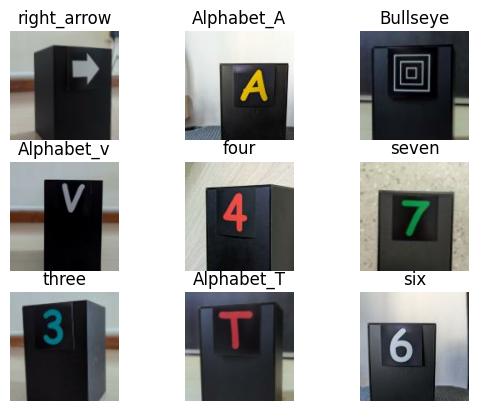

In [123]:
images, labels = next(iter(test_dataset))
preds = mobnetv3_ft(images)
preds = tf.math.argmax(preds, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[int(preds[i])])
    plt.axis("off")

In [ ]:
mobnetv3_ft.save("./models/mobnetv3_ft.keras")

##### effnet

In [180]:
effnetv2 = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    include_preprocessing=True
)

In [181]:
effnetv2.trainable = True

In [182]:
effnetv2.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_11 (Rescaling)       (None, 224, 224, 3)  0           ['input_23[0][0]']               
                                                                                                  
 normalization_4 (Normalization  (None, 224, 224, 3)  0          ['rescaling_11[0][0]']           
 )                                                                                                
                                                                                  

In [183]:
effnetv2_ft = keras.Sequential([
  keras.Input(shape=(224, 224, 3)), 
  data_augmentation,
  layers.Rescaling(255),
  effnetv2,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.5),
  layers.Dense(128, activation="relu"),
  layers.Dense(len(classes))
])

In [184]:
effnetv2_ft.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 rescaling_12 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_16 (Dropout)        (None, 1280)              0         
                                                                 
 dense_27 (Dense)            (None, 128)             

In [185]:
import tensorflow_addons as tfa

#optimizer = keras.optimizers.Adam(learning_rate=0.001)
optimizer = tfa.optimizers.AdamW(weight_decay=0.004, learning_rate=0.001)

In [186]:
effnetv2_ft.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [187]:
epochs = 20

history = effnetv2_ft.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset)

Epoch 1/20


79/79 [==============================] - 55s 467ms/step - loss: 0.9161 - accuracy: 0.7923 - val_loss: 2.0418 - val_accuracy: 0.6512
Epoch 2/20
79/79 [==============================] - 38s 452ms/step - loss: 0.1576 - accuracy: 0.9829 - val_loss: 2.9019 - val_accuracy: 0.2041
Epoch 3/20
79/79 [==============================] - 39s 460ms/step - loss: 0.2088 - accuracy: 0.9682 - val_loss: 2.8323 - val_accuracy: 0.3302
Epoch 4/20
79/79 [==============================] - 40s 469ms/step - loss: 0.2407 - accuracy: 0.9627 - val_loss: 3.1322 - val_accuracy: 0.0798
Epoch 5/20
23/79 [=======>......................] - ETA: 23s - loss: 0.2744 - accuracy: 0.9565

KeyboardInterrupt: 

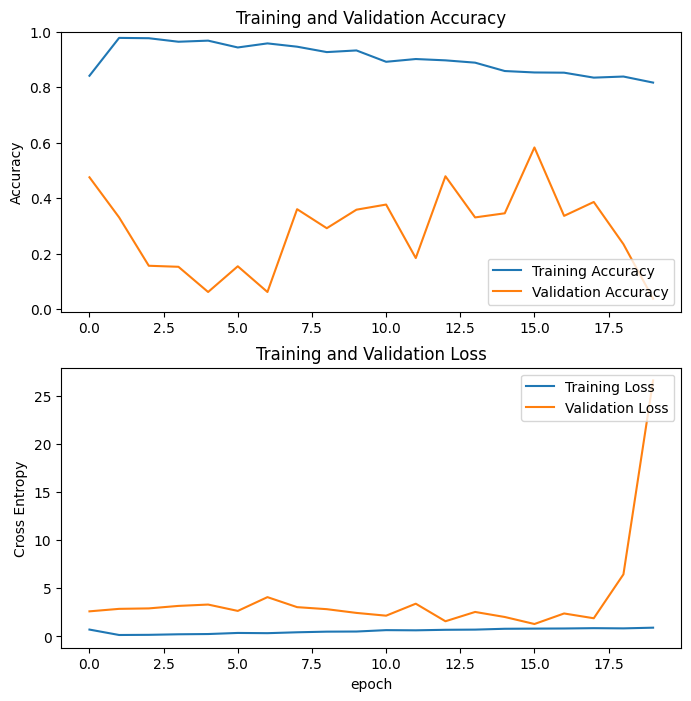

In [172]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [174]:
loss, accuracy = effnetv2_ft.evaluate(test_dataset)
print('Test accuracy :', accuracy)

17/17 [==============================] - 5s 47ms/step - loss: 26.7068 - accuracy: 0.0241
Test accuracy : 0.024118738248944283


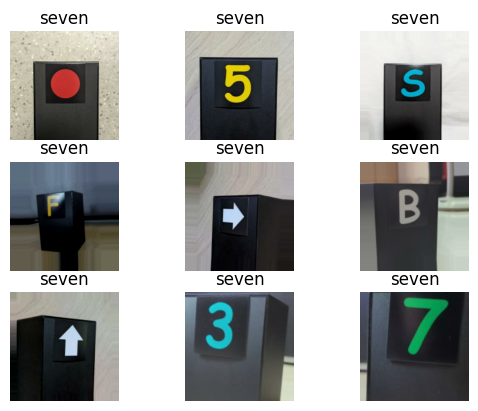

In [178]:
images, labels = next(iter(test_dataset))
preds_logits = effnetv2_ft(images)
preds = tf.math.argmax(preds_logits, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[int(preds[i])])
    plt.axis("off")

In [179]:
preds_logits

<tf.Tensor: shape=(32, 31), dtype=float32, numpy=
array([[-22.748661  ,   1.5991052 , -14.408738  ,   8.349743  ,
        -17.839733  , -34.943615  ,  15.954174  , -18.4915    ,
        -11.606486  ,   8.1125765 , -41.141743  ,  -5.694745  ,
        -30.317625  , -17.52883   ,  -2.364039  , -37.05374   ,
         -1.9640017 , -16.117449  ,  -4.9883223 ,  -5.4596124 ,
         -3.482779  ,  10.73829   ,  -4.897838  ,  13.279088  ,
          7.3839235 , -28.989994  , -18.265867  , -27.690174  ,
        -19.517603  , -14.198797  , -25.267487  ],
       [-21.961391  ,   1.6288494 , -15.0754    ,   8.294411  ,
        -16.465704  , -35.112488  ,  15.952492  , -19.74716   ,
        -11.826566  ,   9.581045  , -40.421825  ,  -6.203665  ,
        -31.980782  , -17.100542  ,  -0.07431044, -36.976723  ,
         -1.8122096 , -17.0255    ,  -4.7401667 ,  -4.2083435 ,
         -2.9132216 ,  10.300262  ,  -6.8312926 ,  13.216392  ,
          9.612999  , -29.491718  , -18.692028  , -27.920948  ,
   